<font color=red size=7>  **_FACIAL RECOGNITION SYSTEM :_**  </font>
    
    
<font size=6>**(EigenFaces and FisherFaces)** </font>

*One normally does not mix, or compare unsupervised learning methods, and supervised ones. This is an exception.*


<font color=red> **Problem Statement:** </font> 
To make a Facial recognition system such that it is very highly <mark> **insensitive to variation in lighting** </mark> direction, intensity and <mark> _facial expressions_ </mark> while still producing recognition results with a good level of <mark> accuracy. </mark>



<font color=red> **Methodology:** </font>
If faces were surfaces such that they had no self shadowing, the images of a same person will all lie in <mark> _3D Linear subspace_ </mark> of the High dimensional image space. Since faces do produce self shadowing, in reality, they won't all lie in a linear subspace. This deviation will be very difficult to model or understand, since it will vary for different people.



So instead, **in this project,** the images are <mark>**projected down to a linear subspace.**</mark> There is a dimensionality reduction such that relevant info hasn't been lost, and the parts of the face with large deviations are discounted.
Not just this, we require (for a good accuracy), that on reduction of dimensions, there is <mark> _best possible seperation between classes_.</mark>



Now since this has become a case for dimensionality reduction and then classification, the following two methods were used and compared:

1.  **Unsupervised learning:**  EigenFaces method
2.  **Supervised learning:** FisherFaces method



<font color=red size=6> **DATASET DETAILS** </font>

The database was taken from Kaggle, called the **AT&T Database of Faces.** Credit to- <mark> *AT&T Laboratories Cambridge.* </mark>

There are *10* different images of each of **40 distinct subjects.** For some subjects, the images were taken at different times, <mark> varying the *lighting, facial expressions* (open / closed eyes, smiling / not smiling) and facial details (*glasses / no glasses*)<mark>. 

There is also some tolerance of side movement.

Some reference pictures of a few subjects are as follows:


<Figure size 432x288 with 0 Axes>

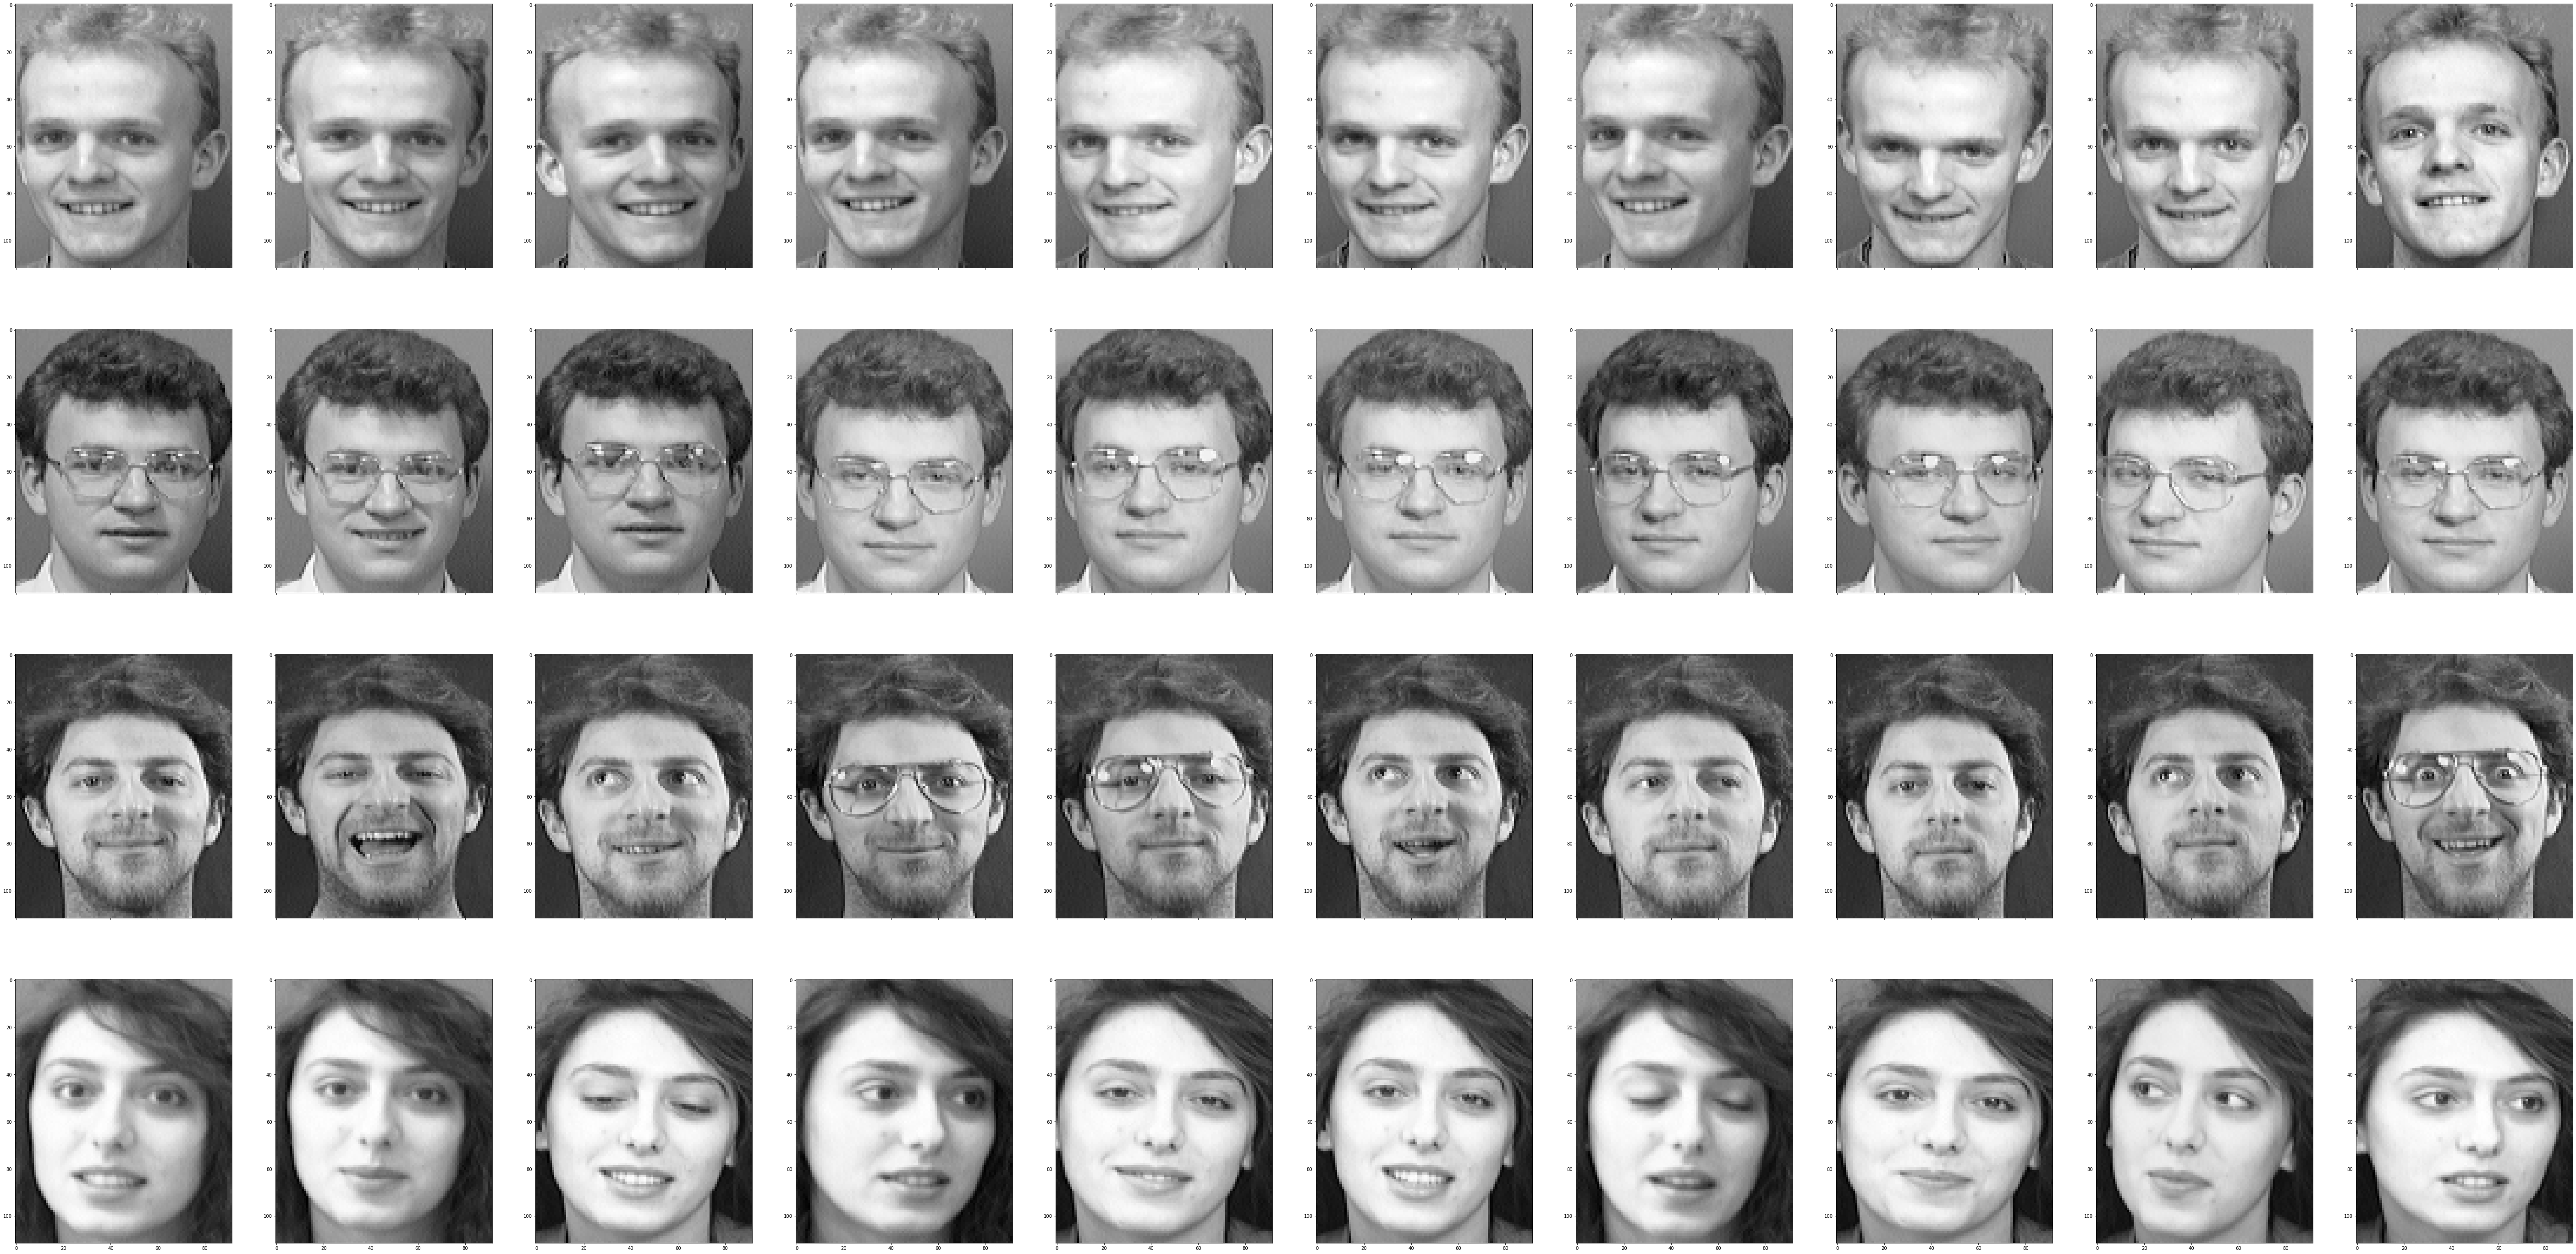

In [57]:
#DISPLAYING SOME REFERENCE IMAGES FROM DATASET


from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
fig, ax = plt.subplots(4,10, figsize=(100,50), sharex=True)

for j in [5,6,7,8]:
    for i in range(1,11):
        f = "D:/SEM 2/Project2/s"+str(j)+"/"+str(i)+".pgm"
        im= Image.open(f)
        ax[j-5,i-1].imshow(im, cmap='gray')



<font color=red size=6> **EigenFaces method** </font>


Here,<mark><font color=red>  **Principal Component Analysis method (PCA)** </mark> </font> was used for dimensionality reduction.

=> In PCA, the direction of projection is chosen such that the <mark> _total scatter is maximized_ </mark>, of all projected samples. 

=> Now, <mark> _the variation in a single person's images under different extreme lighting conditions (and viewing directions) is larger than the variation of images between seperate individuals._ </mark> (**important**)

=> Thus since PCA is maximising the total scatter, it will retain the lighting variations and classifications of different individuals for recognition will not be good in this method.




**Mathematical formulation of PCA:**


If the linear transformation is denoted by: 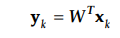



and the Total scatter matrix is:  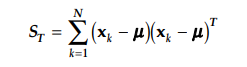

Optimum projection is found to be: 
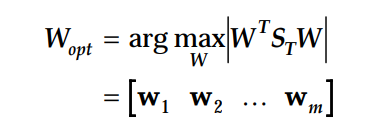

Which is the set of n-dimensional eigenvectors of Scatter matrix corresponding to the m largest eigenvalues,
<br> where:                   

<center> n- original dimensions of image space
<br> m- lower dimension of the feature space. </center>


**The following is the code implementing Eigenfaces method:**


In [55]:
#IMPORTS

import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from PIL import Image
import math
import colorama
from colorama import Fore

In [56]:
#FUNCTION TO DISPLAY IMAGES IN THE OUTPUT FOR COMPARISON LATER

def DISPLAY(path1,path2):
    plt.figure()
    fig, ax = plt.subplots(1,2, figsize=(5,2.5), sharex=True)
    fig.suptitle('Wrong classification:')
    im1= Image.open(path1)
    im2=Image.open(path2)
    ax[0].imshow(im1, cmap='gray')
    ax[1].imshow(im2, cmap='gray')
    
    

In [32]:
#FUNCTION TO COLLECT IMAGE OBJECTS AND THEIR LABELS FROM DIRECTORY AS NUMPY ARRAYS FOR LATER USE

def get_images(path):
    paths = [os.path.join(path, l) for l in os.listdir(path)]
    images=[]
    labels=[]
    x=[]
    for i in paths:
        a=os.path.split(i)[1]
        for j in range(10):
            im_path=i + '/' + str(j+1) +'.pgm'
            image = Image.open(im_path)
            image = np.array(image, 'uint8')
            image=image.flatten()
            images.append(image)
            x.append(j+1)
            labels.append(int(str(a)[1:]))
    images = np.array(images, 'uint8')
    labels = np.array(labels)
    x = np.array(x)
    return images,labels,x

In [68]:
# SPLITTING ALL OF THE DATA INTO 80% TRAINING DATA - 20% TEST DATA

def split_training_and_test(images,labels,x):

    images_train, images_test, labels_train, labels_test, index_train, index_test = train_test_split(images, labels, x, test_size = 0.2, random_state = 0)
    
    return images_train, images_test, labels_train, labels_test, index_train, index_test

In [58]:
#EIGENFACE MODEL: CALCULATING OPTIMAL W (EIGENVECTORS)

def Eigenface_model(images_train, labels_train):
    
    #subtracting mean face from all faces
    
    org=images_train
    images_train = images_train.T
    mean = images_train.mean(axis=1, keepdims=True)
    images_train = images_train - mean
    
    #computing covariance matrix (Total Scatter matrix)
    
    cov = np.matmul(np.transpose(images_train), images_train)
    
    #getting the eigen values and eigen vectors for Scatter matrix
    
    eigval, eigv = np.linalg.eig(cov)
    
    #getting corresponding eigen vectors
    eigu = np.matmul(images_train, eigv.real)
    
    #normalizing eigen vectors by dividing by root(Eigenvalue*Number of images)
    
    a=np.reciprocal(eigval)
    a=np.sqrt(a)
    eigu=np.multiply(eigu,a)
    eigu=1/math.sqrt(len(images_train))*eigu
    

    #arranging eigen values and hence eigen vecs in descending order of eigen values TO GET m LARGEST VALUES LATER
    
    idx = np.argsort(-eigval)
    eigval = eigval[idx]
    eigu = eigu[:, idx]
    

    return eigval, eigu, mean, org

In [64]:
#APPLYING THE ALGORITHM ON TEST IMAGES AND DISPLAYING RESULTS

def Eigenface_test(images_test, labels_test, labels_train, index_train, index_test, weights, mbest, mean):

    #Normalizing the test images
    
    images_test = images_test.T- mean
    labels_test = labels_test.T

    #calculating projected test images
    
    testweights = np.matmul(mbest.T, images_test)
    correct=0
    
    for i in range(0, len(labels_test)):
        
        #calculating sum of square of error error for each test image (FOR DISTANCE FROM CLASSES)
        
        testweight = np.resize(testweights[:, i], (testweights.shape[0], 1))
        err = (weights - testweight) ** 2
        ssq1 = np.sum(err ** (1/2), axis=0)
        

        #Finding the closest face to the test image (MINIMUM SSQ) and getting the corresponding label value
        
        dist= ssq1.min(axis=0, keepdims=True)
        match=labels_train[ssq1.argmin(axis=0)]

        #Checking if results are correct and Printing the result for this image
        t = "D:/SEM 2/Project2/s"+str(labels_test[i])+"/"+str(index_test[i])+".pgm"
        m= "D:/SEM 2/Project2/s"+str(match)+"/"+str(index_train[i])+".pgm"
        
        if dist < 250:
            if labels_test[i] == match:
                correct+=1
                print("subject %s identified correctly as %s with distance %f" %(labels_test[i], match, dist.real))

            else:
                
                print ("subject %s identified incorrectly as %s with distance %f" %(labels_test[i], match, dist.real))
                
                DISPLAY(t,m)
        else:
            print ("subject face not match in database :")
            display(Image.open(t))
            
    print(Fore.RED+ "\033[1m"+ "\n THE FINAL ACCURACY OF EIGENFACES IS %f PERCENT" % (correct*100 / len(labels_test))+ 
          "\033[0;0m")
    return


subject 21 identified correctly as 21 with distance 157.225460
subject 37 identified correctly as 37 with distance 159.695991
subject 40 identified correctly as 40 with distance 191.643131
subject 27 identified correctly as 27 with distance 248.567982
subject 31 identified correctly as 31 with distance 197.252422
subject 15 identified correctly as 15 with distance 101.636631
subject 23 identified correctly as 23 with distance 83.552423
subject 33 identified correctly as 33 with distance 57.230650
subject 22 identified correctly as 22 with distance 152.350004
subject 29 identified correctly as 29 with distance 133.531174
subject 12 identified correctly as 12 with distance 192.587659
subject 21 identified correctly as 21 with distance 138.101405
subject 2 identified correctly as 2 with distance 104.777118
subject 40 identified correctly as 40 with distance 237.039516
subject 10 identified correctly as 10 with distance 167.478978
subject face not match in database :


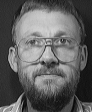

subject 36 identified correctly as 36 with distance 232.884930
subject 22 identified correctly as 22 with distance 136.439691
subject 28 identified correctly as 28 with distance 218.291814
subject 27 identified correctly as 27 with distance 212.512646
subject 25 identified correctly as 25 with distance 149.578979
subject 33 identified correctly as 33 with distance 202.265364
subject 20 identified correctly as 20 with distance 213.757987
subject 40 identified incorrectly as 5 with distance 194.091595
subject 25 identified correctly as 25 with distance 143.662999
subject 38 identified correctly as 38 with distance 187.632222
subject face not match in database :


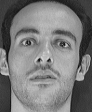

subject 10 identified correctly as 10 with distance 225.838971
subject 35 identified correctly as 35 with distance 207.391073
subject 19 identified correctly as 19 with distance 162.874623
subject 25 identified correctly as 25 with distance 154.515653
subject 37 identified correctly as 37 with distance 233.341119
subject 4 identified correctly as 4 with distance 182.249833
subject 3 identified correctly as 3 with distance 196.433646
subject 15 identified correctly as 15 with distance 157.313414
subject face not match in database :


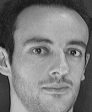

subject 18 identified correctly as 18 with distance 166.128989
subject 25 identified correctly as 25 with distance 198.459286
subject 25 identified correctly as 25 with distance 138.274826
subject 9 identified correctly as 9 with distance 221.595064
subject 19 identified correctly as 19 with distance 118.833730
subject 39 identified correctly as 39 with distance 121.990937
subject face not match in database :


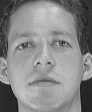

subject face not match in database :


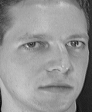

subject 36 identified correctly as 36 with distance 181.660020
subject 14 identified correctly as 14 with distance 170.830329
subject 7 identified correctly as 7 with distance 162.757546
subject 32 identified correctly as 32 with distance 176.059243
subject 23 identified correctly as 23 with distance 194.729570
subject 30 identified correctly as 30 with distance 130.273625
subject 31 identified correctly as 31 with distance 146.423079
subject 22 identified correctly as 22 with distance 143.540970
subject 36 identified correctly as 36 with distance 227.382917
subject 25 identified correctly as 25 with distance 224.401392
subject face not match in database :


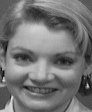

subject 38 identified correctly as 38 with distance 224.958418
subject 14 identified correctly as 14 with distance 88.443713
subject 10 identified correctly as 10 with distance 229.772564
subject 11 identified correctly as 11 with distance 231.105825
subject 13 identified correctly as 13 with distance 243.142514
subject 16 identified correctly as 16 with distance 157.060085
subject 34 identified correctly as 34 with distance 70.155673
subject face not match in database :


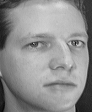

subject 5 identified correctly as 5 with distance 96.466225
subject 27 identified correctly as 27 with distance 144.848046
subject 7 identified correctly as 7 with distance 222.413773
subject 22 identified correctly as 22 with distance 184.035796
subject 1 identified correctly as 1 with distance 239.711833
subject 23 identified correctly as 23 with distance 124.097958
subject 38 identified correctly as 38 with distance 158.806469
subject face not match in database :


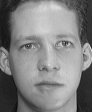

subject 33 identified correctly as 33 with distance 214.589937
subject 15 identified correctly as 15 with distance 142.019834
subject 11 identified correctly as 11 with distance 216.023749
subject 19 identified correctly as 19 with distance 223.359727
subject 10 identified correctly as 10 with distance 230.598779
subject 6 identified correctly as 6 with distance 89.349867
subject 37 identified correctly as 37 with distance 174.944505
subject 6 identified correctly as 6 with distance 142.159488
subject 39 identified correctly as 39 with distance 224.890260

 THE FINAL ACCURACY OF EIGENFACES IS 88.750000 PERCENT


<Figure size 432x288 with 0 Axes>

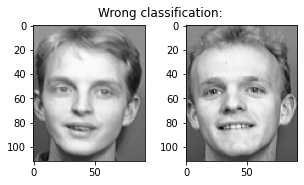

In [62]:
#MAIN PROGRAM: EIGENFACES (Calling all functions)

#Getting the images and labels from Directory

path=('D:/SEM 2/Project2/')
images, labels, x= get_images(path)

#Splitting the data into training and test

images_train, images_test, labels_train, labels_test, index_train, index_test = split_training_and_test(images,labels,x)


#Performing Eigenface analysis and get Eigenface vectors

eigval, eigu, mean, org= Eigenface_model(images_train, labels_train)


#Finding m best eigen vectors for dimension reduction to m dimensions

sum1 = np.sum(eigval, axis=0)
k = 0
for m in range(0, len(labels_train)):
    k += eigval[m] / sum1
    if k > 0.95:
        break
kbest = eigu[:, 0:m]

#Getting the projections of the of eigenfaces for each input image

weights = np.matmul(kbest.T, images_train.T- mean)


#Testing the Eigenface model on the test images and print the result

Eigenface_test(images_test, labels_test, labels_train, index_train, index_test, weights, kbest, mean)




<font color=red size=6> **FisherFaces method** </font>

Here the **Fisher's Linear Discriminant method** combined with the PCA method is used to find the optimum projection.


=> Advantage is taken of the fact that for a given view point, and lighting variations, the images of one particular face will lie in a <mark> 3D Linear subspace. </mark> So three or more images under different lighting conditions can be taken up as basis images for each person's images' subspace.

=> FLD method does a <mark> *class-specific projection* </mark> using learning set, which tries to maximise between-class seperation and minimise within-class seperation.

=> Hence this is a scenario of supervised learning

The Scatter matrices calculated via knowledge from learning set are:

The within class scatter matrix is given by: 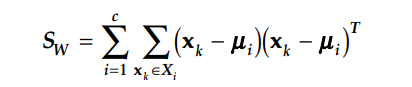

where <center> Xi denotes i-th class </center>

Similarly, between class scatter matrix: 

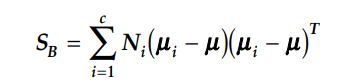

Here the optimal projection will be such that: 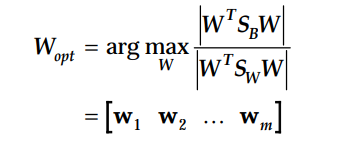

Where the ws are generalised eigenvectors of Sb (between class scatter matrix) and Sw (within class scatter matrix).

for <center>c= number of classes</center>

 <center> n x n= dimension of images </center>
 <center> N = number of images </center>

There are <mark> at most **c-1** </mark> number of such eigenvectors.

Here comes an issue with Singularity of Within class scatter matrix Sw.
For any singular matrix, its rank is less than its order. Here rank of Sw is at maximum = N-c and its order is n x n (Same order as dimensionality of the images). 
Since in general N<<n, **Sw can be singular** .



Hence in this method of FisherFaces, The <mark> *PCA and FLD methods are combined* </mark> to overcome this singularity problem.

=> First PCA reduces the dimension of the feature space to N - c.

=> Then standard FLD defined by reduces the dimension to c - 1.

The final result is: 
 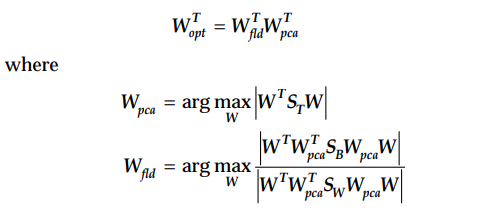

The following code executes the FisherFaces method: 

In [61]:
#FISHERFACE MODEL: FINDING OUT BOTH SCATTER MATRICES AND DOING EIGEN ANALYSIS TO TAKE C-1 EIGENVALUES, 
#EIGENVECTORS FOR DIMENSION REDUCTION

def Fishers_model(images, labels):
    
    #Getting the shape of image variable and the no of classes
    
    d = images.shape [1]
    classes = np.unique(labels)
    
    
    #Initailising the two covariance matrix, Sw- within cluster, Sw- Between clusters
    
    Sw = np.zeros((d, d), dtype=np.float32)
    Sb = np.zeros((d, d), dtype=np.float32)
    
    #Getting the mean of all images 
    totmean=images.mean(axis=0, keepdims=True)
    
    
    #Calculating and updating Sw and Sb according to their formulas
    
    for i in range(0, len(classes)):
        imagesi = images[np.where(labels == i+1)[0], :]
        ni = imagesi.shape[0]
        MEANi = imagesi.mean(axis=0, keepdims=True)
        Sw = Sw + np.matmul((imagesi - MEANi).T, (imagesi - MEANi))
        Sb = Sb + ni * np.matmul((MEANi - totmean).T, (MEANi - totmean))
        
        
    #Getting the eigen values and eigen vectors of the matrix Inv(Sw)*Sb (Generalised Eigenvectors and eigenvalues)
    
    eigval_fld, eigvec_fld = np.linalg.eig(np.linalg.inv(Sw) * Sb)
    
    
    #Sorting eigen vectors and eigen values in decreasing order of the eigenvalues
    idx = np.argsort(-eigval_fld)
    eigval_fld = eigval_fld[idx]
    eigvec_fld = eigvec_fld[:, idx]
    
    #Taking the first c-1 eigenvalues and eigenvectors for dimension reduction to c-1
    
    eigval_fld = eigval_fld[0:(len(classes)-1)]
    eigvec_fld = eigvec_fld[:,0:(len(classes)-1)]
    
    
    return eigval_fld, eigvec_fld


In [53]:
#TESTING THE FISHERS MODEL ON TEST IMAGES AND DISPLAYING RESULTS

def Fishers_test(images_train, images_test, labels_test, labels_train, index_train, index_test, eigvec, mean):
    
    #Getting the projected training images
    
    weights = np.matmul(eigvec.T, images_train)
    
    #Normalizing the test images
    
    images_test = images_test.T - mean
    labels_test = labels_test.T

    #calculating the projected test images
    
    testweights = np.matmul(eigvec.T, images_test)

    correct = 0
    
    #Calculating the error for each test image and find the closest training image and displaying the result
    
    
    for i in range(0, len(labels_test)):
        
        #calculating error for each test image
        
        testweight = np.resize(testweights[:, i], (testweights.shape[0], 1))
        err = (weights - testweight) ** 2

        #calculating the sum of square of error
        ssq1 = np.sum(err **(1/2), axis=0)

        #Finding the closest face to the test image
        
        dist = ssq1.min(axis=0, keepdims=True)
        match = labels_train[ssq1.argmin(axis=0)]

        #Checking if results are correct and printing the results for this image
        
        t = "D:/SEM 2/Project2/s"+str(labels_test[i])+"/"+str(index_test[i])+".pgm"

        m= "D:/SEM 2/Project2/s"+str(match)+"/"+str(index_train[i])+".pgm"
        
        if dist < 230:
            if labels_test[i] == match:
                correct+=1
                print("subject %d identified correctly as %d with distance %f" % (labels_test[i], match, dist.real))
            else:
                print("subject %d identified incorrectly as %d with distance %f" % (labels_test[i], match, dist.real))
                DISPLAY(t,m)
        else:
            print("subject face not match in database:")
            display(Image.open(t))
            
    print(Fore.RED+"\033[1m"+"\n The accuracy of Fisherfaces is %f percent" %(correct*100/len(labels_test))+"\033[0;0m")
    return weights

subject 21 identified correctly as 21 with distance 51.796876
subject 37 identified correctly as 37 with distance 48.604783
subject 40 identified correctly as 40 with distance 72.946407
subject 27 identified correctly as 27 with distance 102.806074
subject 31 identified correctly as 31 with distance 68.236715
subject 15 identified correctly as 15 with distance 26.070898
subject 23 identified correctly as 23 with distance 29.987811
subject 33 identified correctly as 33 with distance 16.285639
subject 22 identified correctly as 22 with distance 40.308813
subject 29 identified correctly as 29 with distance 36.380116
subject 12 identified correctly as 12 with distance 76.627627
subject 21 identified correctly as 21 with distance 43.592639
subject 2 identified correctly as 2 with distance 24.496313
subject 40 identified correctly as 40 with distance 87.269423
subject 10 identified correctly as 10 with distance 55.887696
subject 14 identified correctly as 14 with distance 99.439742
subject 3

<Figure size 432x288 with 0 Axes>

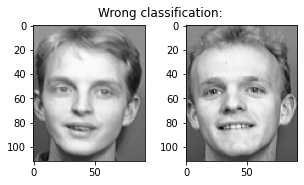

<Figure size 432x288 with 0 Axes>

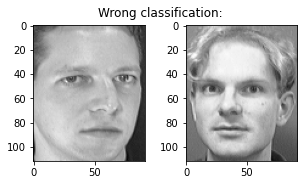

<Figure size 432x288 with 0 Axes>

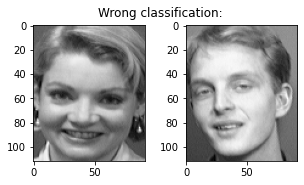

In [63]:
#MAIN PROGRAM: FISHERFACES (Calling all functions)

#Getting the images and labels from directory

path=('D:/SEM 2/Project2/')
images, labels,x= get_images(path)


#Splitting the data into training and test

images_train, images_test, labels_train, labels_test, index_train, index_test = split_training_and_test(images,labels,x)

#Applying Eigenface model first to reduce dimensions to N-c

eigval_pca, eigvec_pca, mean, org= Eigenface_model(images_train, labels_train)
[n,d]= images_train.shape
c = len(np.unique(labels_train))

eigvec_pca1 = eigvec_pca[:,0: n-c]

#Projecting the images onto N-c dimension using PCA
images_train = images_train.T
images_train = images_train - mean
images_train_project = np.matmul(images_train.T, eigvec_pca1)



#Projecting to c-1 dimension using Fishers linear discriminant on the already PCA-projected images of N-c dimensions

eigval_fld, eigvec_fld = Fishers_model( images_train_project, labels_train)


#Getting the total final eigen vectors by multiplying the eigen vectors from PCA and FLD
eigvec= np.matmul(eigvec_pca1,eigvec_fld)


#Testing the Fisherface model on the test images and displaying the result
weights=Fishers_test(images_train, images_test, labels_test, labels_train, index_train, index_test, eigvec, mean)




<font color=red size=6> **RESULTS** </font>

<font color=red>**Eigen Faces** : </font>

=> Accuracy of eigenfaces was **88.75%.**

=> Out of 80 Test images, <mark> *1 was wrongly identified* </mark> as someone else, 
and in <mark> *8 instances*, </mark> subject was claimed to be <mark> *not found in database.* </mark>

<font color=red >**Fisher Faces**: </font>

=> Accuracy of eigenfaces was **96.25%.**

=> Out of 80 Test images, <mark> *3 were wrongly identified* </mark> as someone else, 
and in <mark> *none of the instances,* </mark> subject was claimed to be <mark> *not found in database.* </mark>





AS expected, one sees a **significant improvement of accuracy in the Fisher Faces method compared to the Eigen Faces.**
